In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

plt.rcParams["figure.figsize"] = (12, 4)

#data path
data_path = Path("/Users/rydentamura/Desktop/projects/ecg-projectdata")
train_dir = data_path / "train"

# list downloaded IDs
local_ids = [folder.name for folder in train_dir.iterdir() if folder.is_dir()]
print("Local IDs:", local_ids)

# one sample ID for preprocess
sample_id = local_ids[0]
folder = train_dir / sample_id

# pick the cleanest image (try 0001.png)
pngs = sorted(folder.glob("*0001*.png"))
if len(pngs) == 0:
    pngs = sorted(folder.glob("*.png"))

img_path = pngs[0]
print("Using image:", img_path)


Local IDs: ['1006867983', '1006427285', '1012423188']
Using image: /Users/rydentamura/Desktop/projects/ecg-projectdata/train/1006867983/1006867983-0001.png


In [2]:
#1. helper display image function
def show(img, title="", cmap=None):
    plt.figure(figsize=(12, 4))
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


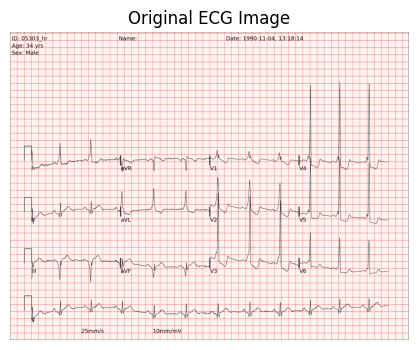

In [3]:
#2. original image loader
# load image (OpenCV loads as BGR)
img_bgr = cv2.imread(str(img_path))

# convert to RGB for display
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

show(img, "Original ECG Image")


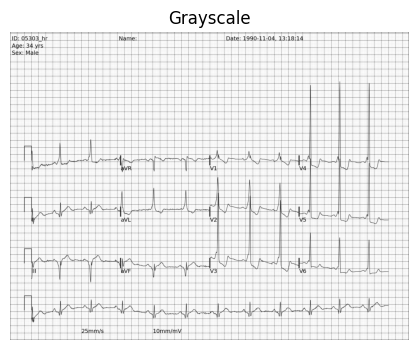

In [4]:
#3. convert to greyscale for simplification
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
show(gray, "Grayscale", cmap="gray")


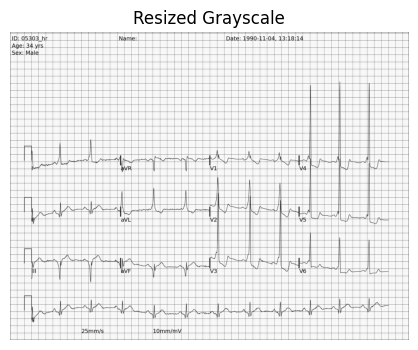

Original shape: (1700, 2200)
New shape: (1582, 2048)


In [5]:
#4. image size normalizer
target_width = 2048
aspect_ratio = gray.shape[0] / gray.shape[1]
target_height = int(target_width * aspect_ratio)

gray_resized = cv2.resize(gray, (target_width, target_height))
show(gray_resized, "Resized Grayscale", cmap="gray")

print("Original shape:", gray.shape)
print("New shape:", gray_resized.shape)


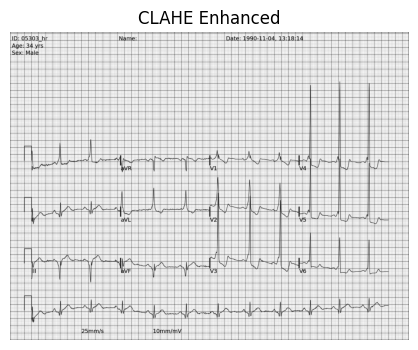

In [6]:
#contrast enchnacement (CLAHE) for curve visibilty 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray_resized)

show(enhanced, "CLAHE Enhanced", cmap="gray")


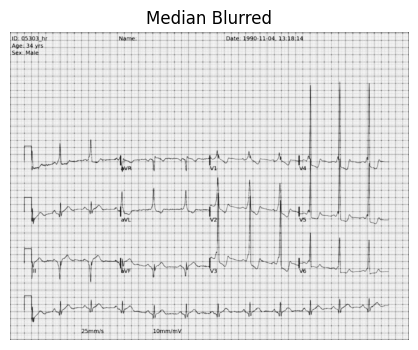

In [7]:
#5. light noise reduction (median blurring) remove speckle noise
# and help edge detection
blur = cv2.medianBlur(enhanced, 5)
show(blur, "Median Blurred", cmap="gray")


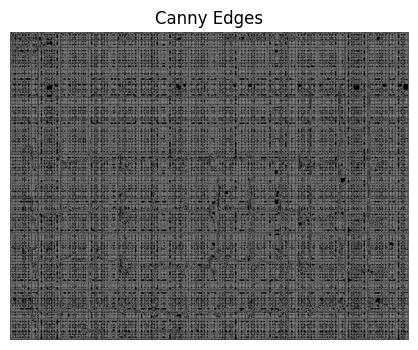

In [8]:
#6. edge detect (Canny) help visulaize wavefrom liines
#isolate ECG curve from graph
edges = cv2.Canny(blur, threshold1=50, threshold2=150)
show(edges, "Canny Edges", cmap="gray")


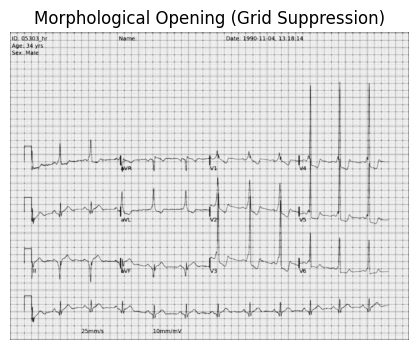

In [9]:
#initial gridline suppression trial - reduce vertical/horizontal 
#straight lines on ECG grids with morphological opening 
kernel = np.ones((3, 3), np.uint8)
opened = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel)

show(opened, "Morphological Opening (Grid Suppression)", cmap="gray")


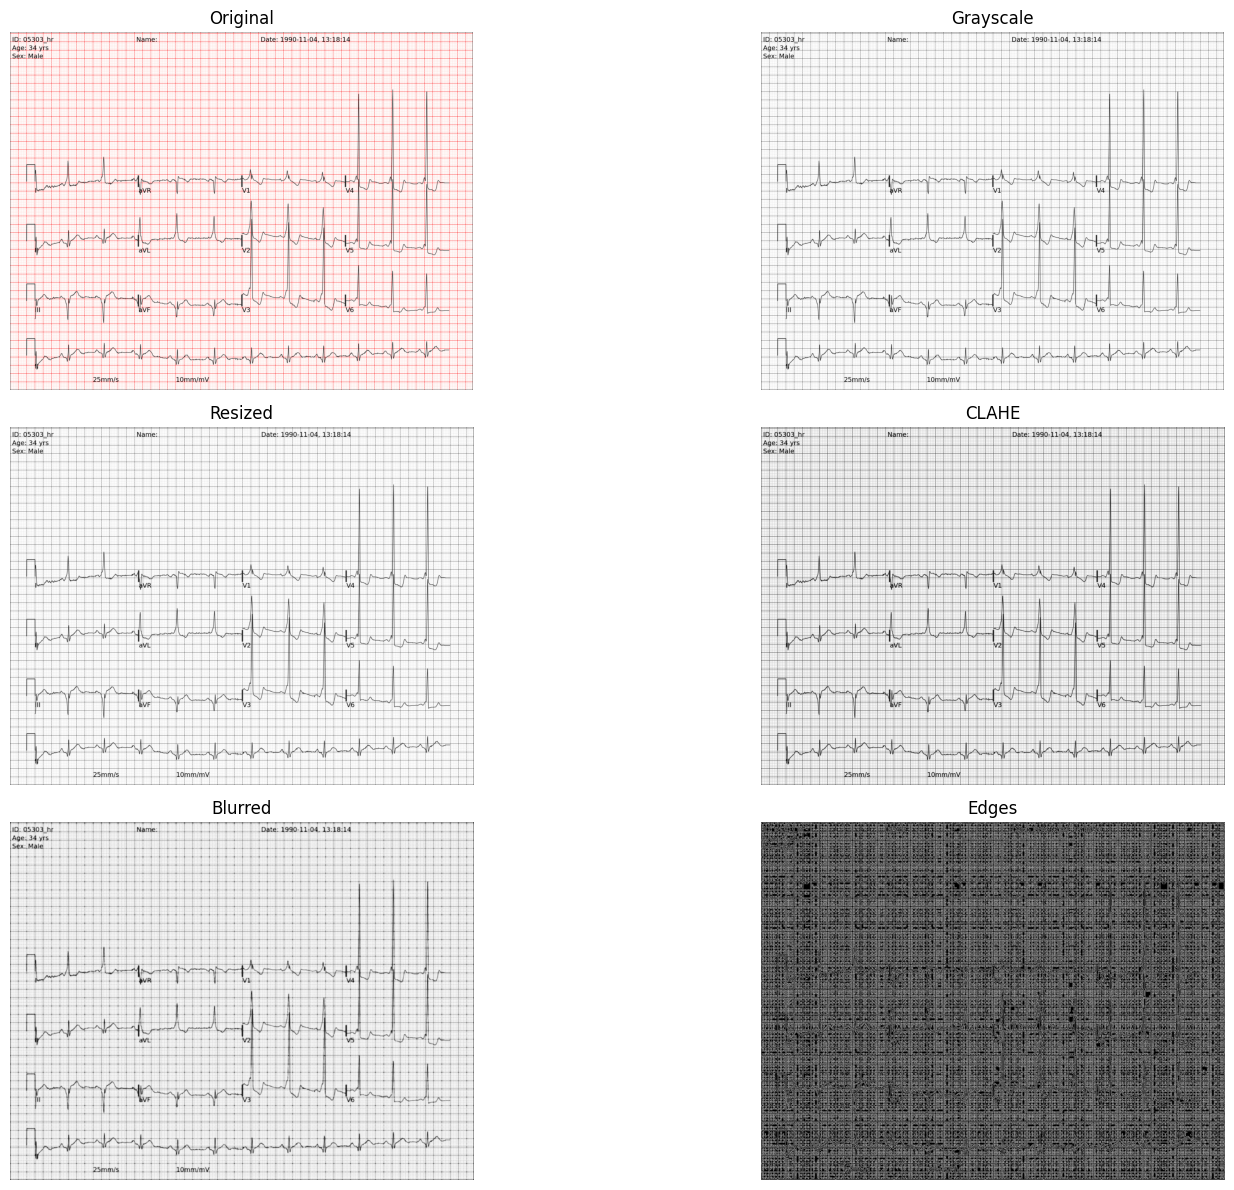

In [11]:
#7. compare all preprocessing steps together
titles = [
    "Original",
    "Grayscale",
    "Resized",
    "CLAHE",
    "Blurred",
    "Edges",
]

images = [
    img,
    gray,
    gray_resized,
    enhanced,
    blur,
    edges,
]

plt.figure(figsize=(18, 12))

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(3, 2, i + 1)
    if len(image.shape) == 2:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()
